# Read in csv for route 4

In [1430]:
#Read into a dataframe a CSV dataset
#Timestamp micro since 1970 01 01 00:00:00 GMT'
#Line ID
#Direction
#Journey Pattern ID
#Time Frame (The start date of the production time table - in Dublin the production time table starts at 6am and ends at 3am)
#Vehicle Journey ID (A given run on the journey pattern)
#Operator (Bus operator, not the driver)
#Congestion [0=no,1=yes]
#Lon WGS84'Lat WGS84'
#Delay (seconds, negative if bus is ahead of schedule)
#Block ID (a section ID of the journey pattern)
#Vehicle ID
#Stop ID
#At Stop [0=no,1=yes]

# the ultimate target feature: delay per stop

# Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, datetime
import numpy

%matplotlib inline

# Read csv file into a dataframe.
df = pd.read_csv('route4.csv')
df.head()

/Users/user/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Timestamp,LineID,Direction,Journey_Pattern_ID,Timeframe,Vehicle_Journey_ID,Operator,Congestion,Lon,Lat,Delay,Block_ID,Vehicle_ID,Stop_ID,At_Stop
0,8,1356998427000000,4.0,0,null,2012-12-31,4243,HN,0,-6.279000,53.416683,0,4001,43043,7226,0
1,20,1356998427000000,4.0,0,00041002,2012-12-31,4599,HN,0,-6.277317,53.415817,0,4012,43035,281,1
2,44,1356998485000000,4.0,0,null,2012-12-31,4243,HN,0,-6.279000,53.416683,0,4001,43043,7226,0
3,46,1356998485000000,4.0,0,00041002,2012-12-31,4599,HN,0,-6.277317,53.415817,0,4012,43035,281,1
4,67,1356998546000000,4.0,0,00041002,2012-12-31,4599,HN,0,-6.277317,53.415817,0,4012,43035,281,1


In [1431]:
df.shape

(689030, 16)

# Remame confusing column headings

In [1432]:
df = df.rename(columns={'Timeframe': 'Start_date'})

# Dropping duplicates

In [1433]:
df=df.drop_duplicates(keep='first')
df.shape

(681530, 16)

In [1434]:
#df.T.drop_duplicates().T
#df.shape

# Dropping constant columns

# Checking for constant columns - cardinality = 1

In [1435]:
for column in df.columns:
    print(column + "," + str(len(df[column].unique())))

Unnamed: 0,563375
Timestamp,387316
LineID,1
Direction,1
Journey_Pattern_ID,7
Start_date,32
Vehicle_Journey_ID,596
Operator,4
Congestion,2
Lon,34662
Lat,28283
Delay,3876
Block_ID,42
Vehicle_ID,116
Stop_ID,242
At_Stop,2


Direction is a constant - that is unexpected
Line is constant as we filtered for line

In [1436]:
df = df.drop('Direction', axis=1)
df = df.drop('Unnamed: 0', axis=1)

The direction is constant, the line ID is only constant due to a filter.

In [1437]:
check_congestion=pd.crosstab(df.Congestion,df.Journey_Pattern_ID, margins=True)
check_congestion

Journey_Pattern_ID,00040001,00040002,00041001,00041002,033X1001,null,All
Congestion,,,,,,,
0,305071,2919,306941,2613,9,60618,678171
1,3033,0,311,0,0,0,3344
All,308104,2919,307252,2613,9,60618,681515


In [1438]:
#congestion accounts for .5% of the dataset - given most peak buses are late this is not a main driving feature
df = df.drop('Congestion', axis=1)

# Add new features

In [1439]:
# Data time`

df["Time"] = pd.to_datetime(df['Timestamp']*1000, unit="ns")

In [1440]:
#binary feature - weekend

df['IsWeekend'] = np.where((df['Time'].dt.dayofweek > 5), 1, 0)

In [1441]:
#hour of day

df['HourOfDay'] = df['Time'].dt.hour

In [1442]:
#binary feature - evening

df['IsEveningTime'] = np.where((df['Time'].dt.hour > 17), 1, 0)

In [1443]:
#binary feature - peak hours

df['IsPeakTime'] = np.where(((df['HourOfDay'] >= 7) & (df['HourOfDay'] <= 10)) | ((df['HourOfDay'] >= 16) & (df['HourOfDay'] <= 19)), 1, 0)

In [1444]:
#binary feature - school holiday

df['SchoolHoliday'] = np.where((df['Time'].dt.date == datetime(2012, 11, 1).date()) | (

df['Time'].dt.date == datetime(2012, 11, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 1).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 2).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 3).date()) | (

                                       df['Time'].dt.date == datetime(2013, 1, 4).date()), 1, 0)

# Merge bus stop info

In [1445]:
df_bus_stop = pd.read_csv('busstopinfo.csv', encoding='latin-1')

In [1446]:
df_bus_stop_route4 = df_bus_stop.loc[(df_bus_stop.route1 == '4')]
df_bus_stop_route4.shape

(49, 43)

So there are 42 official Route 4 stops.

In [1447]:
df_bus_stop_route4 = df_bus_stop_route4.rename(columns={'stopid': 'Stop_ID'})

Get southbound order of stops

In [1448]:
df_northbound = df.loc[(df.Vehicle_ID == 43044) & (df.Vehicle_Journey_ID == 4599) & (df.Start_date == '2013-01-03')]
df_northbound.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday
71084,1357255750000000,4.0,null,2013-01-03,4599,HN,-6.153450,53.288616,0,4012,43044,7330,1,2013-01-03 23:29:10,0,23,1,0,1
71087,1357255765000000,4.0,00041002,2013-01-03,4599,HN,-6.151200,53.289516,0,4012,43044,7330,1,2013-01-03 23:29:25,0,23,1,0,1
71090,1357255787000000,4.0,00041002,2013-01-03,4599,HN,-6.152783,53.288834,0,4012,43044,7330,1,2013-01-03 23:29:47,0,23,1,0,1
71095,1357255806000000,4.0,00041002,2013-01-03,4599,HN,-6.153350,53.288631,0,4012,43044,7330,1,2013-01-03 23:30:06,0,23,1,0,1
71097,1357255810000000,4.0,00041002,2013-01-03,4599,HN,-6.154449,53.288292,0,4012,43044,7330,0,2013-01-03 23:30:10,0,23,1,0,1


In [1449]:
df_subset = df.loc[(df.Vehicle_ID == 43042) & (df.Vehicle_Journey_ID == 4915) & (df.Start_date == '2013-01-31') & (df.At_Stop == 1)]
df_subset.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday
681251,1359617692000000,4.0,00040001,2013-01-31,4915,HN,-6.264970,53.402534,-10,4010,43042,7113,1,2013-01-31 07:34:52,0,7,0,1,0
681260,1359617712000000,4.0,00040001,2013-01-31,4915,HN,-6.264970,53.402534,9,4010,43042,7113,1,2013-01-31 07:35:12,0,7,0,1,0
681317,1359617830000000,4.0,00040001,2013-01-31,4915,HN,-6.263812,53.399124,-50,4010,43042,127,1,2013-01-31 07:37:10,0,7,0,1,0
681348,1359617893000000,4.0,00040001,2013-01-31,4915,HN,-6.264059,53.396149,-85,4010,43042,112,1,2013-01-31 07:38:13,0,7,0,1,0
681356,1359617910000000,4.0,00040001,2013-01-31,4915,HN,-6.264059,53.396149,-64,4010,43042,112,1,2013-01-31 07:38:30,0,7,0,1,0


In [1450]:
df_bus_stop_route4 = df_bus_stop_route4[['Stop_ID', 'fullname']]
df_bus_stop_route4.columns

Index(['Stop_ID', 'fullname'], dtype='object')

In [1451]:
df_south = pd.merge(df_subset, df_bus_stop_route4, on=['Stop_ID'])

df_south.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday,fullname
0,1359617692000000,4.0,00040001,2013-01-31,4915,HN,-6.264970,53.402534,-10,4010,43042,7113,1,2013-01-31 07:34:52,0,7,0,1,0,Ballymun Road
1,1359617712000000,4.0,00040001,2013-01-31,4915,HN,-6.264970,53.402534,9,4010,43042,7113,1,2013-01-31 07:35:12,0,7,0,1,0,Ballymun Road
2,1359617830000000,4.0,00040001,2013-01-31,4915,HN,-6.263812,53.399124,-50,4010,43042,127,1,2013-01-31 07:37:10,0,7,0,1,0,Ballymun Road
3,1359618013000000,4.0,00040001,2013-01-31,4915,HN,-6.263807,53.392265,-88,4010,43042,113,1,2013-01-31 07:40:13,0,7,0,1,0,Ballymun Road
4,1359618412000000,4.0,00040001,2013-01-31,4915,HN,-6.265924,53.372498,-409,4010,43042,147,1,2013-01-31 07:46:52,0,7,0,1,0,Mobhi Road


In [1452]:
df_north = pd.merge(df_northbound, df_bus_stop_route4, on=['Stop_ID'])

df_north.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday,fullname
0,1357255750000000,4.0,null,2013-01-03,4599,HN,-6.153450,53.288616,0,4012,43044,7330,1,2013-01-03 23:29:10,0,23,1,0,1,Monkstown Ave
1,1357255765000000,4.0,00041002,2013-01-03,4599,HN,-6.151200,53.289516,0,4012,43044,7330,1,2013-01-03 23:29:25,0,23,1,0,1,Monkstown Ave
2,1357255787000000,4.0,00041002,2013-01-03,4599,HN,-6.152783,53.288834,0,4012,43044,7330,1,2013-01-03 23:29:47,0,23,1,0,1,Monkstown Ave
3,1357255806000000,4.0,00041002,2013-01-03,4599,HN,-6.153350,53.288631,0,4012,43044,7330,1,2013-01-03 23:30:06,0,23,1,0,1,Monkstown Ave
4,1357255810000000,4.0,00041002,2013-01-03,4599,HN,-6.154449,53.288292,0,4012,43044,7330,0,2013-01-03 23:30:10,0,23,1,0,1,Monkstown Ave


In [1453]:
df_south['stop_order'] = df_south.groupby(['Vehicle_Journey_ID', 'At_Stop', 'Start_date', 'Vehicle_ID'])['Timestamp','Stop_ID'].cumcount().reindex()
df_south.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday,fullname,stop_order
0,1359617692000000,4.0,00040001,2013-01-31,4915,HN,-6.264970,53.402534,-10,4010,...,7113,1,2013-01-31 07:34:52,0,7,0,1,0,Ballymun Road,0
1,1359617712000000,4.0,00040001,2013-01-31,4915,HN,-6.264970,53.402534,9,4010,...,7113,1,2013-01-31 07:35:12,0,7,0,1,0,Ballymun Road,1
2,1359617830000000,4.0,00040001,2013-01-31,4915,HN,-6.263812,53.399124,-50,4010,...,127,1,2013-01-31 07:37:10,0,7,0,1,0,Ballymun Road,2
3,1359618013000000,4.0,00040001,2013-01-31,4915,HN,-6.263807,53.392265,-88,4010,...,113,1,2013-01-31 07:40:13,0,7,0,1,0,Ballymun Road,3
4,1359618412000000,4.0,00040001,2013-01-31,4915,HN,-6.265924,53.372498,-409,4010,...,147,1,2013-01-31 07:46:52,0,7,0,1,0,Mobhi Road,4


In [1454]:
df_north['stop_order'] = df_north.groupby(['Vehicle_Journey_ID', 'At_Stop', 'Start_date', 'Vehicle_ID'])['Timestamp','Stop_ID'].cumcount().reindex()
df_north.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday,fullname,stop_order
0,1357255750000000,4.0,null,2013-01-03,4599,HN,-6.153450,53.288616,0,4012,...,7330,1,2013-01-03 23:29:10,0,23,1,0,1,Monkstown Ave,0
1,1357255765000000,4.0,00041002,2013-01-03,4599,HN,-6.151200,53.289516,0,4012,...,7330,1,2013-01-03 23:29:25,0,23,1,0,1,Monkstown Ave,1
2,1357255787000000,4.0,00041002,2013-01-03,4599,HN,-6.152783,53.288834,0,4012,...,7330,1,2013-01-03 23:29:47,0,23,1,0,1,Monkstown Ave,2
3,1357255806000000,4.0,00041002,2013-01-03,4599,HN,-6.153350,53.288631,0,4012,...,7330,1,2013-01-03 23:30:06,0,23,1,0,1,Monkstown Ave,3
4,1357255810000000,4.0,00041002,2013-01-03,4599,HN,-6.154449,53.288292,0,4012,...,7330,0,2013-01-03 23:30:10,0,23,1,0,1,Monkstown Ave,0


In [1455]:
df_south['stop_order'].groupby(df_south['Journey_Pattern_ID']).max()

Journey_Pattern_ID
00040001    23
Name: stop_order, dtype: int64

In [1456]:
df_north['stop_order'].groupby(df_north['Journey_Pattern_ID']).max()

Journey_Pattern_ID
00041002    45
null         0
Name: stop_order, dtype: int64

In [1457]:
df_order = df_south[['Stop_ID', 'stop_order']]
df_order=df_order.drop_duplicates(subset='Stop_ID', keep='first')
df_order.head()

,Stop_ID,stop_order
0,7113,0
2,127,2
3,113,3
4,147,4
5,273,5


In [1458]:
df_order2 = df_north[['Stop_ID', 'stop_order']]
df_order2=df_order2.drop_duplicates(subset='Stop_ID', keep='first')
frames = [df_order, df_order2]
df_order3 = pd.concat(frames)

In [1459]:
df_bus_stop_route4= pd.merge(df_order3, df_bus_stop_route4, on=['Stop_ID'])

df_bus_stop_route4.head()


,Stop_ID,stop_order,fullname
0,7113,0,Ballymun Road
1,127,2,Ballymun Road
2,113,3,Ballymun Road
3,147,4,Mobhi Road
4,273,5,O'Connell St


In [1460]:
df_bus_stop_route4 = df_bus_stop_route4.drop('stop_order_y', 1)
df_bus_stop_route4.head()

ValueError: labels ['stop_order_y'] not contained in axis

In [1461]:
df = pd.merge(df, df_bus_stop_route4, on=['Stop_ID'])

df.head()

,Timestamp,LineID,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,...,Stop_ID,At_Stop,Time,IsWeekend,HourOfDay,IsEveningTime,IsPeakTime,SchoolHoliday,stop_order,fullname
0,1356998427000000,4.0,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,...,7226,0,2013-01-01 00:00:27,0,0,0,0,1,21,Monkstown Ave
1,1356998485000000,4.0,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,...,7226,0,2013-01-01 00:01:25,0,0,0,0,1,21,Monkstown Ave
2,1356998546000000,4.0,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,...,7226,0,2013-01-01 00:02:26,0,0,0,0,1,21,Monkstown Ave
3,1356998597000000,4.0,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,...,7226,0,2013-01-01 00:03:17,0,0,0,0,1,21,Monkstown Ave
4,1356998607000000,4.0,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,...,7226,0,2013-01-01 00:03:27,0,0,0,0,1,21,Monkstown Ave


In [1462]:
df['stop_order'].groupby(df['Journey_Pattern_ID']).count().T

Journey_Pattern_ID
00040001    93596
00040002      219
00041001    36688
00041002     1020
033X1001        7
null        29854
Name: stop_order, dtype: int64

# Merge weather data

In [1463]:
df_weather = pd.read_csv('weather_data.csv', encoding='latin-1')
df_weather.head(2)

,Date,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
0,01/11/2012 00:00:00,0.0,0.8,NaN,NaN,976.2,0,0
1,01/11/2012 01:00:00,0.0,1.3,6.4,95.0,976.0,0,0


In [1464]:
df_weather.columns

Index(['Date', 'Precipitation (mm)', 'Temperature C',
       'Vapour Pressure (hPa)                ', 'Relative Humidity (%)',
       'Mean Sea Level Pressure (hPa)', 'Rainfall (Yes or No)',
       'Over 1mm Rain?'],
      dtype='object')

In [1465]:
df_weather = df_weather.rename(columns={'Date': 'Time'})
df_weather['Time'] = pd.to_datetime(df_weather['Time'])
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df_weather['HourOfDay'] = df_weather['Time'].dt.hour
df_weather.head(2)

,Time,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?,HourOfDay
0,2012-01-11 00:00:00,0.0,0.8,NaN,NaN,976.2,0,0,0
1,2012-01-11 01:00:00,0.0,1.3,6.4,95.0,976.0,0,0,1


In [1466]:
df.sort_values(['Time'], ascending=[True], inplace=True)
df_weather.sort_values(['Time'], ascending=[True], inplace=True)
df =  pd.merge_asof(df, df_weather, on='Time')
df.columns

Index(['Timestamp', 'LineID', 'Journey_Pattern_ID', 'Start_date',
       'Vehicle_Journey_ID', 'Operator', 'Lon', 'Lat', 'Delay', 'Block_ID',
       'Vehicle_ID', 'Stop_ID', 'At_Stop', 'Time', 'IsWeekend', 'HourOfDay_x',
       'IsEveningTime', 'IsPeakTime', 'SchoolHoliday', 'stop_order',
       'fullname', 'Precipitation (mm)', 'Temperature C',
       'Vapour Pressure (hPa)                ', 'Relative Humidity (%)',
       'Mean Sea Level Pressure (hPa)', 'Rainfall (Yes or No)',
       'Over 1mm Rain?', 'HourOfDay_y'],
      dtype='object')

In [1467]:
#code from here: https://stackoverflow.com/questions/27313647/merging-two-pandas-dataframes-results-in-duplicate-columns

def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

drop_y(df)
df.columns

Index(['Timestamp', 'LineID', 'Journey_Pattern_ID', 'Start_date',
       'Vehicle_Journey_ID', 'Operator', 'Lon', 'Lat', 'Delay', 'Block_ID',
       'Vehicle_ID', 'Stop_ID', 'At_Stop', 'Time', 'IsWeekend', 'HourOfDay_x',
       'IsEveningTime', 'IsPeakTime', 'SchoolHoliday', 'stop_order',
       'fullname', 'Precipitation (mm)', 'Temperature C',
       'Vapour Pressure (hPa)                ', 'Relative Humidity (%)',
       'Mean Sea Level Pressure (hPa)', 'Rainfall (Yes or No)',
       'Over 1mm Rain?'],
      dtype='object')

In [1468]:
def rename_x(df):
    for col in df:
        if col.endswith('_x'):
            df.rename(columns={col:col.rstrip('_x')}, inplace=True)
rename_x(df)
df.columns

Index(['Timestamp', 'LineID', 'Journey_Pattern_ID', 'Start_date',
       'Vehicle_Journey_ID', 'Operator', 'Lon', 'Lat', 'Delay', 'Block_ID',
       'Vehicle_ID', 'Stop_ID', 'At_Stop', 'Time', 'IsWeekend', 'HourOfDay',
       'IsEveningTime', 'IsPeakTime', 'SchoolHoliday', 'stop_order',
       'fullname', 'Precipitation (mm)', 'Temperature C',
       'Vapour Pressure (hPa)                ', 'Relative Humidity (%)',
       'Mean Sea Level Pressure (hPa)', 'Rainfall (Yes or No)',
       'Over 1mm Rain?'],
      dtype='object')

In [1469]:
df.describe()

,Timestamp,LineID,Vehicle_Journey_ID,Lon,Lat,Delay,Block_ID,Vehicle_ID,At_Stop,IsWeekend,...,IsPeakTime,SchoolHoliday,stop_order,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
count,1.613850e+05,161385.0,161385.000000,161385.000000,161385.000000,161385.000000,161385.000000,161385.000000,161385.000000,161385.000000,...,161385.000000,161385.000000,161385.000000,161385.000000,161385.000000,161385.000000,161385.000000,161385.000000,161385.000000,161385.000000
mean,1.358305e+15,4.0,10448.985383,-6.204645,53.322855,-70.750652,13753.356155,41918.405465,0.308802,0.058605,...,0.524894,0.138867,8.685572,0.124085,4.863440,7.273385,83.013849,1009.191760,0.170443,0.037358
std,7.370723e+11,0.0,65076.047859,0.045942,0.037026,336.436101,88738.199837,2819.117939,0.462001,0.234885,...,0.499381,0.345808,8.039121,0.433613,2.624165,1.236206,6.255345,10.355659,0.376023,0.189638
min,1.356998e+15,4.0,4229.000000,-6.312333,53.285683,-2322.000000,4001.000000,33069.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-3.800000,4.500000,58.000000,980.800000,0.000000,0.000000
25%,1.357672e+15,4.0,4569.000000,-6.258871,53.288601,-211.000000,4003.000000,43033.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,0.000000,3.000000,6.400000,82.000000,1000.500000,0.000000,0.000000
50%,1.358323e+15,4.0,4899.000000,-6.195390,53.308392,0.000000,4005.000000,43037.000000,0.000000,0.000000,...,1.000000,0.000000,5.000000,0.000000,5.800000,7.600000,82.000000,1012.700000,0.000000,0.000000
75%,1.358936e+15,4.0,4945.000000,-6.153783,53.347191,46.000000,4009.000000,43042.000000,1.000000,0.000000,...,1.000000,0.000000,18.000000,0.000000,5.800000,7.600000,87.000000,1018.700000,0.000000,0.000000
max,1.359631e+15,4.0,999254.000000,-6.134333,53.418999,4539.000000,822025.000000,43054.000000,1.000000,1.000000,...,1.000000,1.000000,21.000000,4.000000,13.900000,13.300000,100.000000,1021.900000,1.000000,1.000000


# Notes on missing values

In [1470]:
df.isnull().sum()

Timestamp                                0
LineID                                   0
Journey_Pattern_ID                       1
Start_date                               0
Vehicle_Journey_ID                       0
Operator                                 0
Lon                                      0
Lat                                      0
Delay                                    0
Block_ID                                 0
Vehicle_ID                               0
Stop_ID                                  0
At_Stop                                  0
Time                                     0
IsWeekend                                0
HourOfDay                                0
IsEveningTime                            0
IsPeakTime                               0
SchoolHoliday                            0
stop_order                               0
fullname                                 0
Precipitation (mm)                       0
Temperature C                            0
Vapour Pres

It does not appear that any feature has so many missing values that the feature should be dropped right now. So there is no missing value work at the outset. 

# However the string 'null' is a known issue for journey ID - for now remove rows with null. 

In [1471]:
df[df.Journey_Pattern_ID == 'null'].shape

(29854, 28)

Journey pattern ID is null for 60k out of the sample - about 10%

# Looking at the data to check what some features represent by checking their unique values

In [1472]:
df.Operator.unique()

array(['HN', 'D1', 'SL', 'D2'], dtype=object)

This represents bus depot operator (HN being Harristown)

Timeframe is merely date. 

In [1473]:
df.Block_ID.unique()

array([  4001,   4012,   4002,   4003,   4004,   4005,   4007,   4008,
         4009,   4006,   4010, 822025,   4011,   4070,   4075,   4099,
        40312,  40507,   4090,   4085,   4091,   4508,   4501,   4069,
         4068,   4018,   4071,   4072,   4076,   4312,   4507])

Although block ID has 42 unique values, being in line with number of stops intuitively meaning block between stops, this is not a fully understood column as the journey ID does not seem to start or end with block ID consistenty on northbound or southbound routes. More further on individual journey analysis. 

In [1474]:
df.Journey_Pattern_ID.unique()

array(['null', '00041002', '00040001', '00041001', '00040002', '033X1001',
       nan], dtype=object)

So journey pattern ID relates to Block ID as there is a similar pattern but only a selection of block IDs are used. 

Issue is equating the number of journey patters to either daily schedules (weekday, sat, sun, BH perhaps?), directional schedules or variations of the bus route (4A for example). 

In [1475]:
df.Stop_ID.unique()

array(['7226', '281', '7113', '127', '113', '147', '273', '408', '410',
       '412', '414', '416', '418', '424', '426', '428', '6334', '7330',
       '3162', '3164', '422'], dtype=object)

In [1476]:
df['Block_ID'].groupby(df['Journey_Pattern_ID']).count().T

Journey_Pattern_ID
00040001    93596
00040002      219
00041001    36688
00041002     1020
033X1001        7
null        29854
Name: Block_ID, dtype: int64


To find out: Why are there 242 unique stop IDs when the number 4 does not have 242 stops?

Why are we seeing 'nan' here when we have converted to string - what is this and what does this feature really represent:

Is it days of the week schedules (sat/BH/sun/weekday etc)? 
Is it variants on the routes?

Perhaps these do represent direction given there are no variants on the route (A/B etc) decommissioned 4A in 2010 according to this http://www.boards.ie/vbulletin/showthread.php?t=2056040487

In [1477]:
df = df.drop('LineID', 1)
df.shape

(161385, 27)

# Group continuous and categorical data 

In [1478]:
#as we are seeing 'mixed types' warning for column 14 checking the data types:
df.dtypes

Timestamp                                         int64
Journey_Pattern_ID                               object
Start_date                                       object
Vehicle_Journey_ID                                int64
Operator                                         object
Lon                                             float64
Lat                                             float64
Delay                                             int64
Block_ID                                          int64
Vehicle_ID                                        int64
Stop_ID                                          object
At_Stop                                           int64
Time                                     datetime64[ns]
IsWeekend                                         int64
HourOfDay                                         int64
IsEveningTime                                     int64
IsPeakTime                                        int64
SchoolHoliday                                   

In [1479]:
df['IsWeekend'] = df['IsWeekend'].astype('category')
df['HourOfDay'] = df['HourOfDay'].astype('category')
df['IsEveningTime'] = df['IsEveningTime'].astype('category')
df['SchoolHoliday'] = df['SchoolHoliday'].astype('category')
df['IsPeakTime'] = df['IsPeakTime'].astype('category')
df['Operator'] = df['Operator'].astype('category')
df['At_Stop'] = df['At_Stop'].astype('category')
categorical_columns = df.select_dtypes(['category']).columns
categorical_columns

Index(['Operator', 'At_Stop', 'IsWeekend', 'HourOfDay', 'IsEveningTime',
       'IsPeakTime', 'SchoolHoliday'],
      dtype='object')

In [1480]:
continuous_columns = df.select_dtypes(['int64', 'float64']).columns
continuous_columns

Index(['Timestamp', 'Vehicle_Journey_ID', 'Lon', 'Lat', 'Delay', 'Block_ID',
       'Vehicle_ID', 'stop_order', 'Precipitation (mm)', 'Temperature C',
       'Vapour Pressure (hPa)                ', 'Relative Humidity (%)',
       'Mean Sea Level Pressure (hPa)', 'Rainfall (Yes or No)',
       'Over 1mm Rain?'],
      dtype='object')

In [1481]:
df.select_dtypes(['category']).describe().T

,count,unique,top,freq
Operator,161385,4,HN,160812
At_Stop,161385,2,0,111549
IsWeekend,161385,2,0,151927
HourOfDay,161385,19,19,12132
IsEveningTime,161385,2,0,113658
IsPeakTime,161385,2,1,84710
SchoolHoliday,161385,2,0,138974


In [1482]:
df.select_dtypes(['int64', 'float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
Timestamp,161385.0,1.358305e+15,7.370723e+11,1.356998e+15,1.357672e+15,1.358323e+15,1.358936e+15,1.359631e+15
Vehicle_Journey_ID,161385.0,1.044899e+04,6.507605e+04,4.229000e+03,4.569000e+03,4.899000e+03,4.945000e+03,9.992540e+05
Lon,161385.0,-6.204645e+00,4.594237e-02,-6.312333e+00,-6.258871e+00,-6.195390e+00,-6.153783e+00,-6.134333e+00
Lat,161385.0,5.332286e+01,3.702618e-02,5.328568e+01,5.328860e+01,5.330839e+01,5.334719e+01,5.341900e+01
Delay,161385.0,-7.075065e+01,3.364361e+02,-2.322000e+03,-2.110000e+02,0.000000e+00,4.600000e+01,4.539000e+03
Block_ID,161385.0,1.375336e+04,8.873820e+04,4.001000e+03,4.003000e+03,4.005000e+03,4.009000e+03,8.220250e+05
Vehicle_ID,161385.0,4.191841e+04,2.819118e+03,3.306900e+04,4.303300e+04,4.303700e+04,4.304200e+04,4.305400e+04
stop_order,161385.0,8.685572e+00,8.039121e+00,0.000000e+00,2.000000e+00,5.000000e+00,1.800000e+01,2.100000e+01
Precipitation (mm),161385.0,1.240853e-01,4.336129e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
Temperature C,161385.0,4.863440e+00,2.624165e+00,-3.800000e+00,3.000000e+00,5.800000e+00,5.800000e+00,1.390000e+01


# Looking into the journey pattern ID in order to establish what it means

# First run a given run on a route and investigate journey pattern ID vs other features

# Journey Pattern ID 00040001 - southbound bus - appears to be peak schedule

In [1483]:
df_subset = df.loc[(df.Vehicle_ID == 43042) & (df.Vehicle_Journey_ID == 4915) & (df.Start_date == '2013-01-31') & (df.At_Stop == 1)]
df_subset.head()

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
159903,1359617692000000,00040001,2013-01-31,4915,HN,-6.264970,53.402534,-10,4010,43042,...,0,0,Ballymun Road,0.2,5.5,7.4,81.0,1001.4,1,0
159905,1359617712000000,00040001,2013-01-31,4915,HN,-6.264970,53.402534,9,4010,43042,...,0,0,Ballymun Road,0.2,5.5,7.4,81.0,1001.4,1,0
159931,1359617830000000,00040001,2013-01-31,4915,HN,-6.263812,53.399124,-50,4010,43042,...,0,2,Ballymun Road,0.2,5.5,7.4,81.0,1001.4,1,0
159961,1359618013000000,00040001,2013-01-31,4915,HN,-6.263807,53.392265,-88,4010,43042,...,0,3,Ballymun Road,0.2,5.5,7.4,81.0,1001.4,1,0
160015,1359618412000000,00040001,2013-01-31,4915,HN,-6.265924,53.372498,-409,4010,43042,...,0,4,Mobhi Road,0.2,5.5,7.4,81.0,1001.4,1,0


In [1484]:
df_subset.head()

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
159903,1359617692000000,00040001,2013-01-31,4915,HN,-6.264970,53.402534,-10,4010,43042,...,0,0,Ballymun Road,0.2,5.5,7.4,81.0,1001.4,1,0
159905,1359617712000000,00040001,2013-01-31,4915,HN,-6.264970,53.402534,9,4010,43042,...,0,0,Ballymun Road,0.2,5.5,7.4,81.0,1001.4,1,0
159931,1359617830000000,00040001,2013-01-31,4915,HN,-6.263812,53.399124,-50,4010,43042,...,0,2,Ballymun Road,0.2,5.5,7.4,81.0,1001.4,1,0
159961,1359618013000000,00040001,2013-01-31,4915,HN,-6.263807,53.392265,-88,4010,43042,...,0,3,Ballymun Road,0.2,5.5,7.4,81.0,1001.4,1,0
160015,1359618412000000,00040001,2013-01-31,4915,HN,-6.265924,53.372498,-409,4010,43042,...,0,4,Mobhi Road,0.2,5.5,7.4,81.0,1001.4,1,0


In [1485]:
for column in df_subset.columns:
    print(column + "," + str(len(df_subset[column].unique())))

Timestamp,24
Journey_Pattern_ID,1
Start_date,1
Vehicle_Journey_ID,1
Operator,1
Lon,19
Lat,18
Delay,19
Block_ID,1
Vehicle_ID,1
Stop_ID,17
At_Stop,1
Time,24
IsWeekend,1
HourOfDay,2
IsEveningTime,1
IsPeakTime,1
SchoolHoliday,1
stop_order,17
fullname,12
Precipitation (mm),2
Temperature C,2
Vapour Pressure (hPa)                ,2
Relative Humidity (%),2
Mean Sea Level Pressure (hPa),2
Rainfall (Yes or No),1
Over 1mm Rain?,1


Comments: timestamps are out of order, this subset starts later than it finishes. 
The delay of being 49 seconds ahead of schedule is not in line with the 1 hour schedule from Harristown to Monkstown. So the delay is against a schedule of 1 hour 30 minutes. This is a peak time - Thursday 31/1/2013. 
Block ID: 4010 - stays constant
Journey pattern ID: 00040001
This is a Southbound bus.

In [1486]:
df_subset1 = df.loc[(df.Vehicle_ID == 33219) & (df.Vehicle_Journey_ID == 963581) & (df.Start_date == '2013-01-31') ]
df_subset1.to_csv("southbound.csv", encoding='utf-8', index=False)
df_subset1.head()

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
160937,1359626709000000,00040001,2013-01-31,963581,HN,-6.26497,53.402534,-174,4069,33219,...,0,0,Ballymun Road,0.0,6.1,7.5,79.0,1004.9,0,0
160942,1359626731000000,00040001,2013-01-31,963581,HN,-6.26497,53.402534,-154,4069,33219,...,0,0,Ballymun Road,0.0,6.1,7.5,79.0,1004.9,0,0
160945,1359626761000000,00040001,2013-01-31,963581,HN,-6.26497,53.402534,-134,4069,33219,...,0,0,Ballymun Road,0.0,6.1,7.5,79.0,1004.9,0,0
160947,1359626774000000,00040001,2013-01-31,963581,HN,-6.26497,53.402534,-114,4069,33219,...,0,0,Ballymun Road,0.0,6.1,7.5,79.0,1004.9,0,0
160951,1359626791000000,00040001,2013-01-31,963581,HN,-6.26497,53.402534,-94,4069,33219,...,0,0,Ballymun Road,0.0,6.1,7.5,79.0,1004.9,0,0


In [1487]:
for column in df_subset1.columns:
    print(column + "," + str(len(df_subset1[column].unique())))

Timestamp,56
Journey_Pattern_ID,1
Start_date,1
Vehicle_Journey_ID,1
Operator,1
Lon,45
Lat,45
Delay,36
Block_ID,1
Vehicle_ID,1
Stop_ID,14
At_Stop,2
Time,56
IsWeekend,1
HourOfDay,2
IsEveningTime,1
IsPeakTime,2
SchoolHoliday,1
stop_order,14
fullname,10
Precipitation (mm),1
Temperature C,2
Vapour Pressure (hPa)                ,2
Relative Humidity (%),2
Mean Sea Level Pressure (hPa),2
Rainfall (Yes or No),1
Over 1mm Rain?,1


Comments: the timestamps are out of order again, so the bus in fact finishes at 11.08 on the Monkstown Link Road, not at 10:55 on Merrion Road.
The journey delay is 25 mins ahead of schedule for a trip that began at 10.02 and finished at 11.08 which indicates that the 1 hour published schedule is not right as we should be 6 minutes behind schedule - clearly the real expected time was an hour and a half here - that is the same as the example above but this is much later in the morning - should adhere to the offpeak schedule?
Again this is a southbound bus, so comparable to the journey above except for peak/offpeak.
Again block ID is constant but for the same jouney in same direction it is 4069 - so different. 
Therefore block ID cannot represent the section of the journey pattern as per the instructions given on Moodle. But journey pattern ID is still 00040001 - so that is a bus from Harristown to Monkstown.
Congestion is zero even though this is a peak time bus run so not clear what drives the congestion column. 

# Journey Pattern ID 00041002 - northbound bus - offpeak schedule

In [1488]:
df_subset2 = df.loc[(df.Vehicle_ID == 43044) & (df.Vehicle_Journey_ID == 4599) & (df.Start_date == '2013-01-03')]
df_subset2.head(2)

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
15777,1357255750000000,null,2013-01-03,4599,HN,-6.15345,53.288616,0,4012,43044,...,1,0,Monkstown Ave,0.0,5.8,7.6,82.0,1018.7,0,0
15778,1357255765000000,00041002,2013-01-03,4599,HN,-6.15120,53.289516,0,4012,43044,...,1,0,Monkstown Ave,0.0,5.8,7.6,82.0,1018.7,0,0


In [1489]:
for column in df_subset2.columns:
    print(column + "," + str(len(df_subset2[column].unique())))

Timestamp,54
Journey_Pattern_ID,2
Start_date,1
Vehicle_Journey_ID,1
Operator,1
Lon,43
Lat,42
Delay,11
Block_ID,1
Vehicle_ID,1
Stop_ID,4
At_Stop,2
Time,54
IsWeekend,1
HourOfDay,2
IsEveningTime,2
IsPeakTime,1
SchoolHoliday,1
stop_order,3
fullname,4
Precipitation (mm),1
Temperature C,1
Vapour Pressure (hPa)                ,1
Relative Humidity (%),1
Mean Sea Level Pressure (hPa),1
Rainfall (Yes or No),1
Over 1mm Rain?,1


Comments: again the timestamps are out of order. This is a Northbound bus. We lose it due to date filter near the end of it's trip. However it has travelled from Monkstown to O'Connell Street in 30 mins so it seems to be going on the offpeak scedule - 1 hour. 
The Northbound journey pattern ID is  	00041002.
The block ID is constant but unrelated to journey pattern at: 4012
HN - Harristown is the operator even though this but is travelling in the opposite direction - so operator is not reflective of starting bus depot - just the operator depot for this route it seems. Note this is the last run of a day (the 11.30pm bus).

# Journey Pattern ID 00041001 - northbound bus - offpeak schedule

In [1490]:
df_subset3 = df.loc[(df.Vehicle_ID == 43039) & (df.Vehicle_Journey_ID == 4954) & (df.Start_date == '2013-01-31')]
df_subset3.head(2)

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
161245,1359629257000000,00041001,2013-01-31,4954,HN,-6.157933,53.287117,47,4007,43039,...,0,0,Monkstown Ave,0.0,6.1,7.5,79.0,1004.9,0,0
161255,1359629401000000,00041001,2013-01-31,4954,HN,-6.166802,53.290535,-17,4007,43039,...,0,4,Rowan Pk,0.0,6.1,7.5,79.0,1004.9,0,0


This bus is going Northbound, but cuts off around 11AM.
Possibly one of the filters changes at 11AM.

In [1491]:
df_subset3 = df.loc[ (df.Vehicle_Journey_ID == 4954) & (df.Start_date == '2013-01-31')]
df_subset3.head()

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
161245,1359629257000000,00041001,2013-01-31,4954,HN,-6.157933,53.287117,47,4007,43039,...,0,0,Monkstown Ave,0.0,6.1,7.5,79.0,1004.9,0,0
161255,1359629401000000,00041001,2013-01-31,4954,HN,-6.166802,53.290535,-17,4007,43039,...,0,4,Rowan Pk,0.0,6.1,7.5,79.0,1004.9,0,0
161257,1359629413000000,00041001,2013-01-31,4954,HN,-6.166490,53.291435,-17,4007,43039,...,0,4,Rowan Pk,0.0,6.1,7.5,79.0,1004.9,0,0
161263,1359629499000000,00041001,2013-01-31,4954,HN,-6.171226,53.297417,-75,4007,43039,...,0,4,Stradbrook Rd,0.0,6.1,7.5,79.0,1004.9,0,0
161267,1359629511000000,00041001,2013-01-31,4954,HN,-6.175163,53.299015,-108,4007,43039,...,0,4,Stradbrook Rd,0.0,6.1,7.5,79.0,1004.9,0,0


In [1492]:
for column in df_subset3.columns:
    print(column + "," + str(len(df_subset3[column].unique())))

Timestamp,9
Journey_Pattern_ID,1
Start_date,1
Vehicle_Journey_ID,1
Operator,1
Lon,7
Lat,7
Delay,7
Block_ID,1
Vehicle_ID,1
Stop_ID,3
At_Stop,1
Time,9
IsWeekend,1
HourOfDay,1
IsEveningTime,1
IsPeakTime,1
SchoolHoliday,1
stop_order,2
fullname,3
Precipitation (mm),1
Temperature C,1
Vapour Pressure (hPa)                ,1
Relative Humidity (%),1
Mean Sea Level Pressure (hPa),1
Rainfall (Yes or No),1
Over 1mm Rain?,1


No, having tried without the filters this bus stops on Rock Road only 12 minutes into its journey. 
GPS tracking issues?
This bus is different on Journey Pattern ID to the previous northbound buses, its Journey Pattern ID is 00041001. Also as before the block ID is constant but not in line with other journeys in same area/direction 4007.

In [1493]:
df_subset4 = df.loc[(df.Vehicle_ID == 43046) & (df.Vehicle_Journey_ID == 15476) & (df.Start_date == '2013-01-01')]
df_subset4.to_csv("northbound.csv", encoding='utf-8', index=False)

This is a northbound bus - taking approx 58 minutes but coming in at only 19 seconds ahead of schedule. This was a bank holiday so this bus is travelling in non peak period. What is driving the different Journey Pattern ID _ possibly the non - peak period. It travels the same route with the same operator. The block ID is 4001 so it does tie into the Journey_Pattern_ID this time, unlike before. 


# Journey Pattern ID 00040002 - southbound bus - offpeak schedule

In [1494]:
#df[df['Journey_Pattern_ID'] == '00040002']

In [1495]:
df_subset5 = df.loc[(df.Vehicle_ID == 43047) & (df.Vehicle_Journey_ID == 4570) & (df.Start_date == '2013-01-25')]
df_subset5.head(2)

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,...,SchoolHoliday,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?
138067,1359156835000000,00040002,2013-01-25,4570,HN,-6.264701,53.401489,-87,4003,43047,...,0,0,Ballymun Road,0.0,5.9,7.0,74.0,1000.1,0,0
138070,1359156854000000,00040002,2013-01-25,4570,HN,-6.264701,53.401489,-66,4003,43047,...,0,0,Ballymun Road,0.0,5.9,7.0,74.0,1000.1,0,0


Friday 25 Jan 2013 was a Friday but this is an offpeak bus.  It drops off at 11.51pm which is too early to be because of the date in the filter. It is a Southbound bus, last of the day. 

This bus has same vehicle journey ID on a different date - but it is the last bus Southbound for the day. Again it drops off when it reaches Parnell Square, not making the full journey. 


# Have established that the 5th number in Journey Pattern ID indicates direction - 0 southbound, 1 northbound

In [1496]:
#splice direction from JourneyPatternID and create new binary column
df["Direction_Northbound"] =  np.where((df["Journey_Pattern_ID"].str[5] == '1'),1, 0)


# Block ID Analysis

In [1497]:
block_df = df[df['Block_ID'] == 4001]
block_df.head(2)

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Lon,Lat,Delay,Block_ID,Vehicle_ID,...,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?,Direction_Northbound
0,1356998427000000,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,43043,...,21,Monkstown Ave,0.0,3.1,6.8,88.0,1000.2,0,0,0
3,1356998485000000,null,2012-12-31,4243,HN,-6.279,53.416683,0,4001,43043,...,21,Monkstown Ave,0.0,3.1,6.8,88.0,1000.2,0,0,0


In [1498]:
for column in block_df.columns:
    print(column + "," + str(len(block_df[column].unique())))

Timestamp,23036
Journey_Pattern_ID,3
Start_date,32
Vehicle_Journey_ID,58
Operator,1
Lon,6021
Lat,5578
Delay,1579
Block_ID,1
Vehicle_ID,39
Stop_ID,21
At_Stop,2
Time,23036
IsWeekend,2
HourOfDay,19
IsEveningTime,2
IsPeakTime,2
SchoolHoliday,2
stop_order,18
fullname,14
Precipitation (mm),23
Temperature C,119
Vapour Pressure (hPa)                ,65
Relative Humidity (%),38
Mean Sea Level Pressure (hPa),213
Rainfall (Yes or No),2
Over 1mm Rain?,2
Direction_Northbound,1


Notes: This highlights nothing about the use of block ID. We may not need it. 

# Drop for 1st model- not for good

In [1499]:
df = df.drop('Lat', axis=1)

In [1500]:
df = df.drop('Lon', axis=1)

In [1501]:
df = df.drop('Block_ID', axis=1)

In [1502]:
df.head(2)

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Delay,Vehicle_ID,Stop_ID,At_Stop,Time,...,stop_order,fullname,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?,Direction_Northbound
0,1356998427000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:00:27,...,21,Monkstown Ave,0.0,3.1,6.8,88.0,1000.2,0,0,0
1,1356998427000000,00041002,2012-12-31,4599,HN,0,43035,281,1,2013-01-01 00:00:27,...,6,O'Connell St,0.0,3.1,6.8,88.0,1000.2,0,0,0


In [1503]:
df.columns

Index(['Timestamp', 'Journey_Pattern_ID', 'Start_date', 'Vehicle_Journey_ID',
       'Operator', 'Delay', 'Vehicle_ID', 'Stop_ID', 'At_Stop', 'Time',
       'IsWeekend', 'HourOfDay', 'IsEveningTime', 'IsPeakTime',
       'SchoolHoliday', 'stop_order', 'fullname', 'Precipitation (mm)',
       'Temperature C', 'Vapour Pressure (hPa)                ',
       'Relative Humidity (%)', 'Mean Sea Level Pressure (hPa)',
       'Rainfall (Yes or No)', 'Over 1mm Rain?', 'Direction_Northbound'],
      dtype='object')

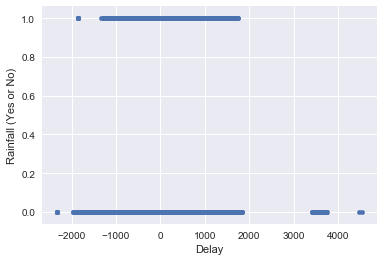

In [1504]:
df.plot(kind='scatter', x='Delay', y='Rainfall (Yes or No)')

KeyError: 'IsWeekend'

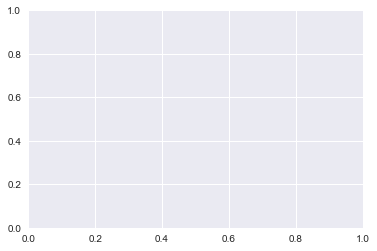

In [1505]:
df.plot(kind='scatter', x='Delay', y='IsWeekend')

KeyError: 'IsPeakTime'

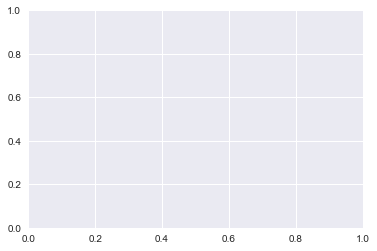

In [1506]:
df.plot(kind='scatter', x='Delay', y='IsPeakTime')

KeyError: 'SchoolHoliday'

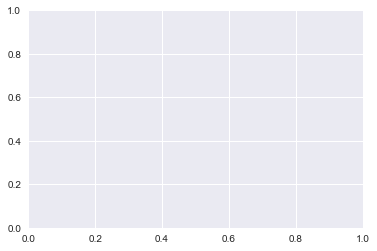

In [1507]:
df.plot(kind='scatter', x='Delay', y='SchoolHoliday')

In [1508]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
import statsmodels.formula.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor

# Linear model - need a time vs distance to generate speed in km/hour

The delay is in seconds. We need to prepare a model that compares to delay for testing. 

We need distance in stops or in real distances based on lon/lat positions
We need, if using stops, to assume an equal distance between stops
% Distance will be stop_order_number / total number of stops 
Time will be % distance * overall schedule time (which is 60 minutes per the offpeak #4 bus schedule)
That should give a base schedule to check against. 
Real delay is per the dataframe. 
To model a delay we need to add features to time function above 
To model a correct time function we should take stop_order(min) from stop_order(current) Timestamp

In [1509]:
df['time_diff'] = df.groupby('stop_order')['Time'].diff()

In [1549]:
df.time_diff.interpolate()
df.head()

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Delay,Vehicle_ID,Stop_ID,At_Stop,Time,...,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?,Direction_Northbound,time_diff,%_distance_travelled
0,1356998427000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:00:27,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,NaT,1.000000
2,1356998485000000,00041002,2012-12-31,4599,HN,0,43035,281,1,2013-01-01 00:01:25,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:00:58,0.285714
4,1356998546000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:02:26,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:01:01,1.000000
6,1356998597000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:03:17,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:00:51,1.000000
7,1356998607000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:03:27,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:00:10,1.000000


In [1550]:

df['%_distance_travelled'] = df.stop_order.div(df.stop_order.max(), axis='index')

In [1551]:
df=df.drop_duplicates(subset='Time', keep='first')

In [1554]:
df

,Timestamp,Journey_Pattern_ID,Start_date,Vehicle_Journey_ID,Operator,Delay,Vehicle_ID,Stop_ID,At_Stop,Time,...,Precipitation (mm),Temperature C,Vapour Pressure (hPa),Relative Humidity (%),Mean Sea Level Pressure (hPa),Rainfall (Yes or No),Over 1mm Rain?,Direction_Northbound,time_diff,%_distance_travelled
0,1356998427000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:00:27,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,NaT,1.000000
2,1356998485000000,00041002,2012-12-31,4599,HN,0,43035,281,1,2013-01-01 00:01:25,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:00:58,0.285714
4,1356998546000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:02:26,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:01:01,1.000000
6,1356998597000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:03:17,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:00:51,1.000000
7,1356998607000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:03:27,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:00:10,1.000000
9,1356998665000000,00041002,2012-12-31,4292,HN,0,43035,281,0,2013-01-01 00:04:25,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:00:58,0.285714
10,1356998669000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:04:29,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:01:02,1.000000
11,1356998726000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:05:26,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:00:57,1.000000
13,1356998786000000,null,2012-12-31,4243,HN,0,43043,7226,0,2013-01-01 00:06:26,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:01:00,1.000000
15,1356998847000000,null,2012-12-31,4292,HN,0,43035,281,0,2013-01-01 00:07:27,...,0.0,3.1,6.8,88.0,1000.2,0,0,0,00:01:01,0.285714


In [1553]:
# linear model

mod_1 = sm.ols(formula=" Delay ~   time_diff", data=df).fit()

print(mod_1.summary())

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


Jarque-Bera - means this data is not normally distributed using the inputs - so linear regression is useless as it relies on that assumption. Backed up by Omnibus vaue 
R squared with 1 being best and 0 being worst is v good at .96
P values v good at 0
A prefered model should have a minimum AIC value - this is good at -1.2.
Small confidence intervals that do not cross zero

#Noting that the issue is that the 'delay' itself is invalid as not operating off 60 minutes in all cases but that is out of scope for first iteration model.

In [1420]:
# Checking the predictions
Delay_predicted = ((mod_1.predict(df)) > 100) * 1.0
df['Delay_predicted'] = Delay_predicted

pd.crosstab([df["Delay"]>1],[df["Delay_predicted"]],margins=True)

Delay_predicted,0.0,All
Delay,,
False,111335,111335
True,50050,50050
All,161385,161385


In [1421]:
df_new = df
df_new.index


Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            161375, 161376, 161377, 161378, 161379, 161380, 161381, 161382,
            161383, 161384],
           dtype='int64', length=161385)